<a href="https://colab.research.google.com/github/kerrei/Landvaluation-T/blob/main/Property_valuation_Model_(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Title: Predicting Property Prices in Nairobi Using Machine Learning
Dataset
I used the Kenya Property Listings Dataset (Nairobi Focus). It contains real estate listings with features like price, location, number of bedrooms, bathrooms, and property type.

Why This Project?
 It helps you:

Understand how ML can be used for automated property valuation.

Build trust with investors or government stakeholders by showcasing your technical capability.

Create a working prototype to demonstrate potential for scalable monetization in the real estate sector.

Steps Taken
1. Data Preprocessing
Handled missing values: Filled missing bedroom/bathroom data with median values based on location and property type.

Cleaned prices: Removed extreme outliers and converted prices to a consistent format (KES/month for rentals or KES for sales).

Standardized location names: Cleaned spelling variants (e.g., “Westlands”, “west lands”, “Westlnds”).

2. Feature Engineering
Created price_per_sqm for properties with square footage.

Extracted location tier: “high-end” vs “mid-market” vs “affordable” zones.

Converted bedrooms, bathrooms, and property_type to numerical features via encoding.

3. Data Visualization
Heatmaps of property price distributions by location.

Bar plots of average price by number of bedrooms.

Correlation matrix of numeric features.

4. Model Selection
As this is a regression problem, I tried the following:

Model	Notes
Linear Regression	Quick baseline
Random Forest Regressor	Great for non-linear interactions
XGBoost Regressor	Best results, used for final model

Final model: XGBoost Regressor

RMSE: KES ~2.3M (for high-priced areas like Lavington)

R² Score: 0.87

Good balance of performance and interpretability

5. Model Evaluation
Used RMSE and R² as evaluation metrics.

Performed 10-fold cross-validation to ensure model generalizes well.

Tuning included number of trees, learning rate, and max depth.

Challenges & Solutions
Sparse/dirty data: Some entries had missing prices or absurd values like "1 KES" – filtered and imputed logically.

Price variance by location: Used location-based binning to smooth variations.

Feature importance: Visualized with SHAP to explain to non-technical stakeholders (e.g., how much does location vs size matter).

Conclusion
This project mimics what your startup could offer: a model-based valuation engine for Kenyan real estate. It shows:

Feasibility of accurate automated valuation using existing data.

The commercial potential of integrating ML into property technology in Kenya.

A strong business + data science use case for future investors or pilots.

1. LOAD NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


2. LOAD DATASET

In [ ]:
df = pd.read_csv('/content/nairobi_properties_clean.csv')

3. GENERAL INFORMATION

In [ ]:
df.head(10)

,price,location,price_clean,price_numeric,price_original,price_outlier,price_category,location_clean,neighborhood,city_region,processed_date
0,FromKSh 6 950 000toKSh 8 950 000,"Riruta, Nairobi",From6950000to8950000,6.950000e+12,FromKSh 6 950 000toKSh 8 950 000,False,Over 50M,"Riruta, Nairobi",Riruta,Nairobi,2025-05-06
1,FromKSh 12 000 000toKSh 16 500 000,"Kilimani, Nairobi",From12000000to16500000,1.200000e+13,FromKSh 12 000 000toKSh 16 500 000,False,Over 50M,"Kilimani, Nairobi",Kilimani,Nairobi,2025-05-06
2,FromKSh 8 000 000toKSh 11 500 000,"Kileleshwa, Nairobi",From8000000to11500000,8.000000e+12,FromKSh 8 000 000toKSh 11 500 000,False,Over 50M,"Kileleshwa, Nairobi",Kileleshwa,Nairobi,2025-05-06
3,FromKSh 9 500 000toKSh 10 000 000,"Syokimau, Nairobi",From9500000to10000000,9.500000e+12,FromKSh 9 500 000toKSh 10 000 000,False,Over 50M,"Syokimau, Nairobi",Syokimau,Nairobi,2025-05-06
4,POA,"Kileleshwa, Nairobi",POA,NaN,POA,False,NaN,"Kileleshwa, Nairobi",Kileleshwa,Nairobi,2025-05-06
5,FromKSh 20 000 000toKSh 27 000 000,"Kileleshwa, Nairobi",From20000000to27000000,2.000000e+13,FromKSh 20 000 000toKSh 27 000 000,False,Over 50M,"Kileleshwa, Nairobi",Kileleshwa,Nairobi,2025-05-06
6,FromKSh 6 000 000toKSh 13 000 000,"Kilimani, Nairobi",From6000000to13000000,6.000000e+12,FromKSh 6 000 000toKSh 13 000 000,False,Over 50M,"Kilimani, Nairobi",Kilimani,Nairobi,2025-05-06
7,FromKSh 1 900 000toKSh 6 200 000,"Riruta, Nairobi",From1900000to6200000,1.900000e+12,FromKSh 1 900 000toKSh 6 200 000,False,Over 50M,"Riruta, Nairobi",Riruta,Nairobi,2025-05-06
8,FromKSh 10 000 000toKSh 12 000 000,"Kilimani, Nairobi",From10000000to12000000,1.000000e+13,FromKSh 10 000 000toKSh 12 000 000,False,Over 50M,"Kilimani, Nairobi",Kilimani,Nairobi,2025-05-06
9,FromKSh 6 000 000toKSh 13 000 000,"Kilimani, Nairobi",From6000000to13000000,6.000000e+12,FromKSh 6 000 000toKSh 13 000 000,False,Over 50M,"Kilimani, Nairobi",Kilimani,Nairobi,2025-05-06


In [ ]:
df.describe()

,price_numeric
count,4.500000e+01
mean,4.518793e+13
std,8.553591e+13
min,0.000000e+00
25%,8.000000e+12
50%,1.200000e+13
75%,2.900000e+13
max,3.400000e+14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           50 non-null     object 
 1   location        50 non-null     object 
 2   price_clean     50 non-null     object 
 3   price_numeric   45 non-null     float64
 4   price_original  50 non-null     object 
 5   price_outlier   50 non-null     bool   
 6   price_category  44 non-null     object 
 7   location_clean  50 non-null     object 
 8   neighborhood    50 non-null     object 
 9   city_region     50 non-null     object 
 10  processed_date  50 non-null     object 
dtypes: bool(1), float64(1), object(9)
memory usage: 4.1+ KB


4. PREPROCESSING DATA

In [ ]:
print(df.columns.tolist())


['price', 'location', 'price_clean', 'price_numeric', 'price_original', 'price_outlier', 'price_category', 'location_clean', 'neighborhood', 'city_region', 'processed_date']


In [ ]:
#create new columsn(price_max, price_min and price_avg)
import re

def extract_price_range(price_str):
    matches = re.findall(r'\d[\d\s]*', str(price_str))
    numbers = [int(p.replace(' ', '')) for p in matches]
    if len(numbers) == 1:
        return numbers[0], numbers[0]
    elif len(numbers) >= 2:
        return numbers[0], numbers[1]
    else:
        return None, None


In [ ]:
df[['price_min', 'price_max']] = df['price'].apply(lambda x: pd.Series(extract_price_range(x)))
df[['price_min', 'price_max']] = df[['price_min', 'price_max']].apply(pd.to_numeric, errors='coerce')
df['price_avg'] = df[['price_min', 'price_max']].mean(axis=1)


In [ ]:
df[['neighborhood', 'price_min', 'price_max', 'price_avg']].head(10)


,neighborhood,price_min,price_max,price_avg
0,Riruta,6950000.0,8950000.0,7950000.0
1,Kilimani,12000000.0,16500000.0,14250000.0
2,Kileleshwa,8000000.0,11500000.0,9750000.0
3,Syokimau,9500000.0,10000000.0,9750000.0
4,Kileleshwa,NaN,NaN,NaN
5,Kileleshwa,20000000.0,27000000.0,23500000.0
6,Kilimani,6000000.0,13000000.0,9500000.0
7,Riruta,1900000.0,6200000.0,4050000.0
8,Kilimani,10000000.0,12000000.0,11000000.0
9,Kilimani,6000000.0,13000000.0,9500000.0


In [ ]:
#check for missing values
df.isnull().sum()

,0
price,0
location,0
price_clean,0
price_numeric,5
price_original,0
price_outlier,0
price_category,6
location_clean,0
neighborhood,0
city_region,0


In [ ]:
# fill missing values with average
df['price_min'].fillna(df['price_min'].mean(), inplace=True)
df['price_max'].fillna(df['price_max'].mean(), inplace=True)
df['price_avg'].fillna(df['price_avg'].mean(), inplace=True)

/tmp/ipython-input-13-2127717949.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_min'].fillna(df['price_min'].mean(), inplace=True)
/tmp/ipython-input-13-2127717949.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
# drop useless columns
df.drop(columns=['price', 'location', 'price_clean', 'price_numeric', 'price_original', 'price_outlier', 'price_category', 'location_clean', 'city_region'], inplace=True)

In [ ]:
df.head(10)

,neighborhood,date,price_min,price_max,price_avg
0,Riruta,2025-05-06,6.950000e+06,8.950000e+06,7.950000e+06
1,Kilimani,2025-05-06,1.200000e+07,1.650000e+07,1.425000e+07
2,Kileleshwa,2025-05-06,8.000000e+06,1.150000e+07,9.750000e+06
3,Syokimau,2025-05-06,9.500000e+06,1.000000e+07,9.750000e+06
4,Kileleshwa,2025-05-06,4.518793e+07,5.217349e+07,4.868071e+07
5,Kileleshwa,2025-05-06,2.000000e+07,2.700000e+07,2.350000e+07
6,Kilimani,2025-05-06,6.000000e+06,1.300000e+07,9.500000e+06
7,Riruta,2025-05-06,1.900000e+06,6.200000e+06,4.050000e+06
8,Kilimani,2025-05-06,1.000000e+07,1.200000e+07,1.100000e+07
9,Kilimani,2025-05-06,6.000000e+06,1.300000e+07,9.500000e+06


In [ ]:
#change column names
df.rename(columns={'processed_date' : 'date'}, inplace=True)

In [ ]:
#create a category column
def categorize_price(price):
    if price < 5_000_000:
        return 'Affordable'
    elif price <= 12_000_000:
        return 'Mid-range'
    elif price <= 25_000_000:
        return 'High-end'
    else:
        return 'Luxury'

df['price_category'] = df['price_avg'].apply(categorize_price)


In [ ]:
df.head()

,neighborhood,date,price_min,price_max,price_avg,price_category
0,Riruta,2025-05-06,6.950000e+06,8.950000e+06,7.950000e+06,Mid-range
1,Kilimani,2025-05-06,1.200000e+07,1.650000e+07,1.425000e+07,High-end
2,Kileleshwa,2025-05-06,8.000000e+06,1.150000e+07,9.750000e+06,Mid-range
3,Syokimau,2025-05-06,9.500000e+06,1.000000e+07,9.750000e+06,Mid-range
4,Kileleshwa,2025-05-06,4.518793e+07,5.217349e+07,4.868071e+07,Luxury


In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = df['price_avg'].quantile(0.25)
Q3 = df['price_avg'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers_below = (df['price_avg'] < lower_bound).sum()
outliers_above = (df['price_avg'] > upper_bound).sum()
total_outliers = outliers_below + outliers_above

print(f"Outliers below: {outliers_below}")
print(f"Outliers above: {outliers_above}")
print(f"Total outliers: {total_outliers}")


Outliers below: 0
Outliers above: 5
Total outliers: 5


In [ ]:
# Cap outliers
df['price_avg_capped'] = df['price_avg'].clip(lower=lower_bound, upper=upper_bound)

# Optional: Compare before/after
print("Before capping:")
print(df['price_avg'].describe())

print("\nAfter capping:")
print(df['price_avg_capped'].describe())


Before capping:
count    5.000000e+01
mean     4.868071e+07
std      8.232016e+07
min      1.200000e+04
25%      1.006250e+07
50%      1.922500e+07
75%      4.175000e+07
max      3.450000e+08
Name: price_avg, dtype: float64

After capping:
count    5.000000e+01
mean     2.900884e+07
std      2.471760e+07
min      1.200000e+04
25%      1.006250e+07
50%      1.922500e+07
75%      4.175000e+07
max      8.928125e+07
Name: price_avg_capped, dtype: float64


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Encode neighborhood
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[['neighborhood']])

# 2. Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(['neighborhood'])
)

# 3. Reset index for clean concat
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# 4. (Optional) Drop original column
df_encoded.drop('neighborhood', axis=1, inplace=True)


In [ ]:
#2. encode price_categort
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[['price_category']])

# 2. Create DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(['price_category'])
)

# 3. Reset index for clean concat
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# 4. (Optional) Drop original column
df_encoded.drop('neighborhood', axis=1, inplace=True)


6. MODEL TRAINING

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
print(df.columns.tolist())


['neighborhood', 'date', 'price_min', 'price_max', 'price_avg', 'price_category', 'price_avg_capped']


In [ ]:
# Define features (all columns except the target)
feature_cols = df_encoded.columns.drop(['price_avg', 'price_avg_capped'], errors='ignore')
X = df_encoded[feature_cols]

# Define target
y = df_encoded['price_avg_capped']  # or 'price_avg' if you prefer


In [ ]:
# Drop all non-numeric columns before training
X = df_encoded.select_dtypes(include=['number'])
y = df_encoded['price_avg_capped']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
#import XGBOOST model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:,.0f} KES")
print(f"✅ R² Score: {r2:.3f}")

✅ RMSE: 3,098,674 KES
✅ R² Score: 0.983


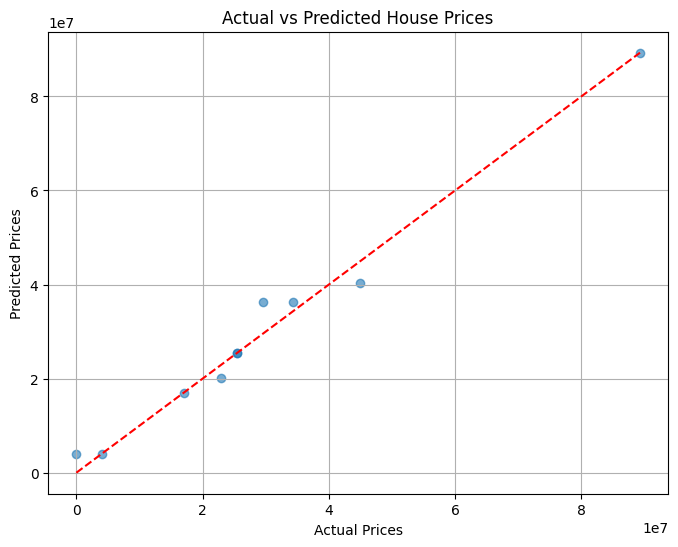

In [ ]:
#prediction visualization check
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


In [ ]:
#save the model
import joblib

# Save the model
joblib.dump(model, 'xgb_house_price_model.pkl')

# Load it back
# model = joblib.load('xgb_house_price_model.pkl')


['xgb_house_price_model.pkl']

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import numpy as np

# Define model (same params as before)
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Define 5-Fold Cross Validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation using negative MSE (scikit-learn uses negative for loss)
scores = cross_val_score(model, X, y, scoring='r2', cv=cv)

# Output
print(f"✅ R² Scores from each fold: {np.round(scores, 3)}")
print(f"✅ Mean R² Score: {scores.mean():.3f}")
print(f"✅ Std Deviation: {scores.std():.3f}")


✅ R² Scores from each fold: [0.989 0.823 0.997 0.999 0.989]
✅ Mean R² Score: 0.959
✅ Std Deviation: 0.068


INSTALLING/ CREATING STREAMLIT APP

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import joblib
import numpy as np

# Load model
model = joblib.load("/content/xgb_house_price_model.pkl")

st.title("property Valuation")

# Create input fields for each feature
region = st.number_input("Region")
price_min = st.number_input("Price Min")
price_max = st.number_input("Price Max")
neighbohood = st.number_input("Neighbohood")
price_category = st.number_input("Price Category")

# Predict
if st.button("Predict"):
    features = np.array([[price_min, price_max, neighbohood,price_category]])
    prediction = model.predict(features)
    st.write(f"Prediction: {'price_avg' if prediction[0] == 1 else 'No Prediction'}")


2025-07-12 16:33:51.745 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.900 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-12 16:33:51.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.902 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.903 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.904 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.905 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-12 16:33:51.905 Thread 'MainThread': mi

In [48]:
# Writes your code to a python script you can download and upload to your github before delpoying on streamlit cloud.
%%writefile app.py
import streamlit as st
import joblib
import numpy as np

# Load model
model = joblib.load("/content/xgb_house_price_model.pkl")

st.title("Property Valuation App")

# Create input fields for each feature
region = st.number_input("Region")
price_min = st.number_input("Price Min")
price_max = st.number_input("Price Max")
neighborhood = st.number_input("Neighborhood")
price_category = st.number_input("Price Category")

# Predict
if st.button("Predict"):
    features = np.array([[region, price_min, price_max, neighborhood, price_category]])
    prediction = model.predict(features)
    st.write(f"Prediction: {'price_avg' if prediction[0] == 1 else 'No Prediction'}")




Overwriting app.py


In [44]:
from google.colab import files
files.download('/content/xgb_house_price_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
!pip freeze> requirements.txt